# Advanced Lane Detection

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle
import helpers
from lane_detection import LaneDetection

# Initiate The Lane Detection Pipeline
pipeline = LaneDetection()

## Camera Calibration

In [2]:
try:
    # load mtx and dist from pickle file if it already exists
    dist_pickle = pickle.load(open("camera_cal/dist_pickle.p", "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
except (OSError, IOError) as e:
    # calculate mtx and dist from cv2.calibrateCamera and save using the method below
    pipeline.calibrate_camera("camera_cal/calibration*.jpg")

## Undistortion

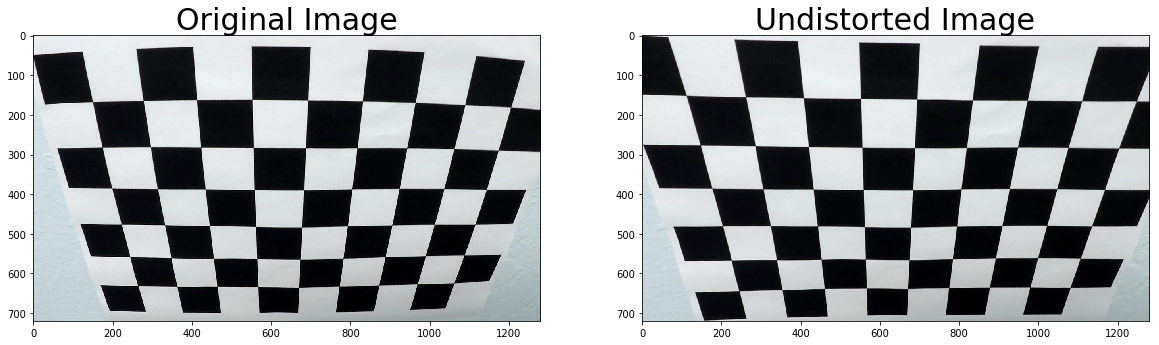

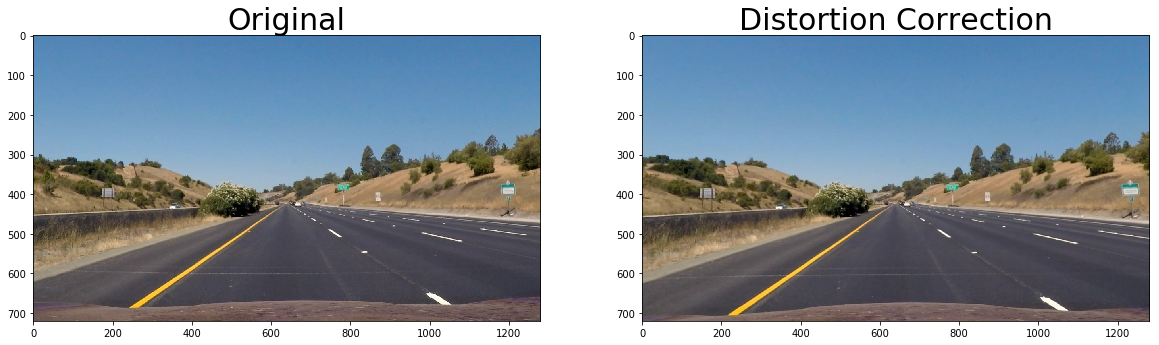

In [3]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')

dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
helpers.side_by_side((img, dst), ('Original Image', 'Undistorted Image'))

# Now with a road image
road_img = cv2.imread('test_images/straight_lines1.jpg')
road_img = cv2.cvtColor(road_img, cv2.COLOR_BGR2RGB)
road_img_corrected = cv2.undistort(road_img, mtx, dist, None, mtx)

helpers.side_by_side(
    (road_img, road_img_corrected), 
    ('Original', 'Distortion Correction'))


## Color & Gradient Thresholds

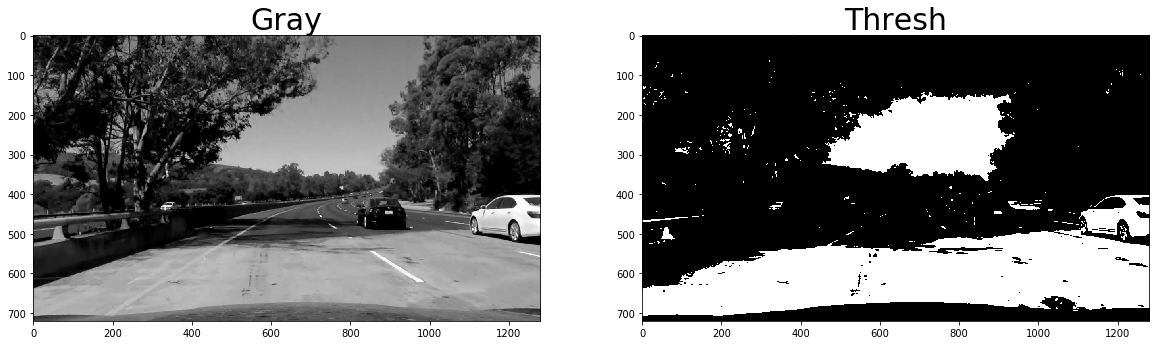

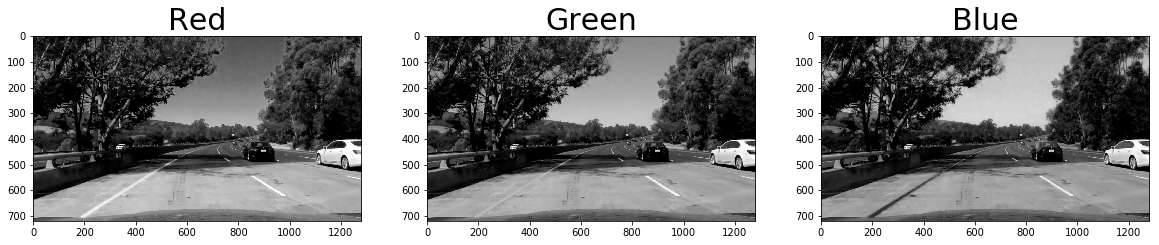

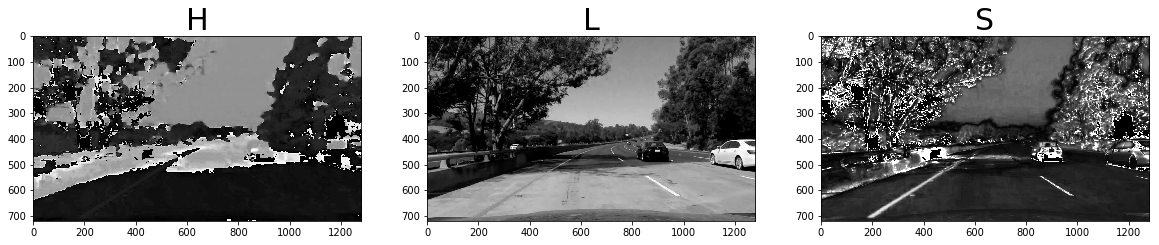

In [4]:
# Let's start experimenting with different color selection and thresholding techniques

road = cv2.imread('test_images/test5.jpg')
road = pipeline.distortion_correction(road)

gray = cv2.cvtColor(road, cv2.COLOR_BGR2GRAY)
gray_thresh = np.zeros_like(gray)
gray_thresh[(gray >= 150) & (gray <= 255)] = 1

red = road[:, :, 2]
green = road[:, :, 1]
blue = road[:, :, 0]

hls = cv2.cvtColor(road, cv2.COLOR_BGR2HLS)
h_channel = hls[:, :, 0]
l_channel = hls[:, :, 1]
s_channel = hls[:, :, 2]

helpers.side_by_side(
    (gray, gray_thresh), 
    ('Gray', 'Thresh'), 
    'gray', 
    cols=2)

helpers.side_by_side(
    (red, green, blue), 
    ('Red', 'Green', 'Blue'), 
    'gray', 
    cols=3)

helpers.side_by_side(
    (h_channel, l_channel, s_channel), 
    ('H', 'L', 'S'), 
    'gray', 
    cols=3)

## Perspective Transform

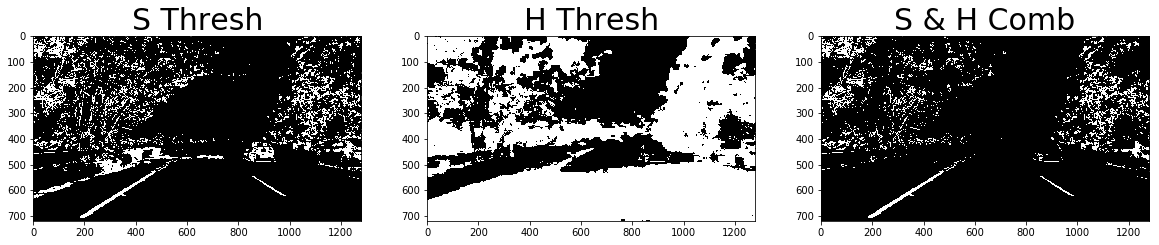

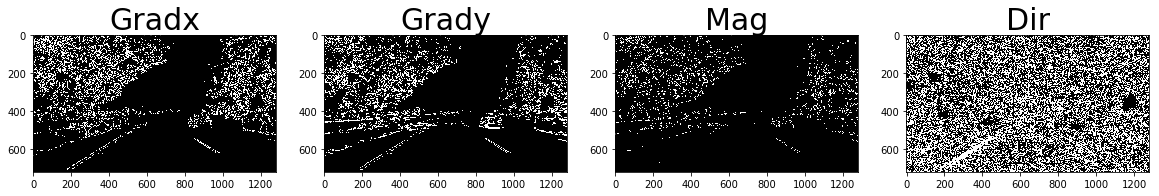

In [5]:
ksize=5
base = s_channel
gradx = pipeline.abs_sobel_thresh(base, orient='x', sobel_kernel=ksize, thresh=(30, 100))
grady = pipeline.abs_sobel_thresh(base, orient='y', sobel_kernel=ksize, thresh=(50, 255))
mag_binary = pipeline.mag_thresh(base, sobel_kernel=ksize, thresh=(90, 140))
dir_binary = pipeline.dir_threshold(base, sobel_kernel=ksize, thresh=(0.7, 1.40))

s_binary = pipeline.s_threshold(road, thresh=(120, 255))
h_binary = pipeline.h_threshold(road, thresh=(20, 120))

s_h_comb = np.zeros_like(s_binary)
s_h_comb[((s_binary == 1) & (h_binary == 1))] = 1

helpers.side_by_side(
    (s_binary, h_binary, s_h_comb), 
    ('S Thresh', 'H Thresh', 'S & H Comb'), 
    'gray', 
    cols=3)

helpers.side_by_side(
    (gradx, grady, mag_binary, dir_binary), 
    ('Gradx', 'Grady', 'Mag', 'Dir'), 
    'gray', 
    cols=4)

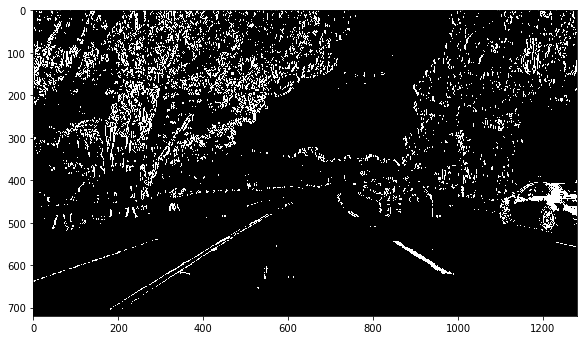

In [38]:
# final combined thresholding
combined = pipeline.combined_threshold(road)

plt.figure(figsize=(10,5.625))
plt.imshow(combined, cmap='gray')

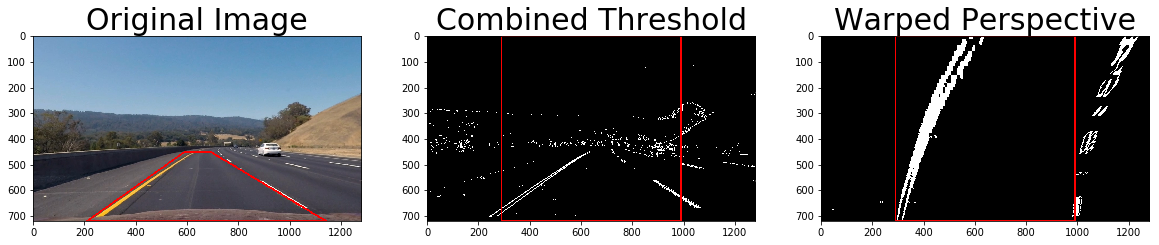

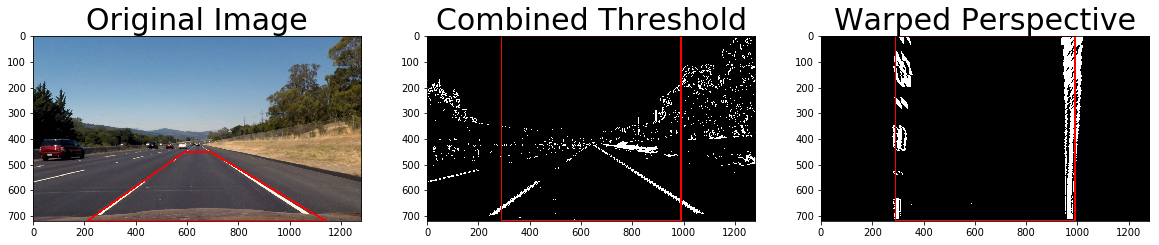

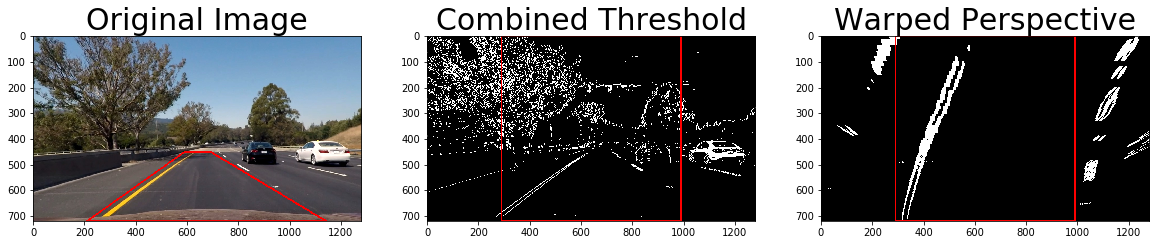

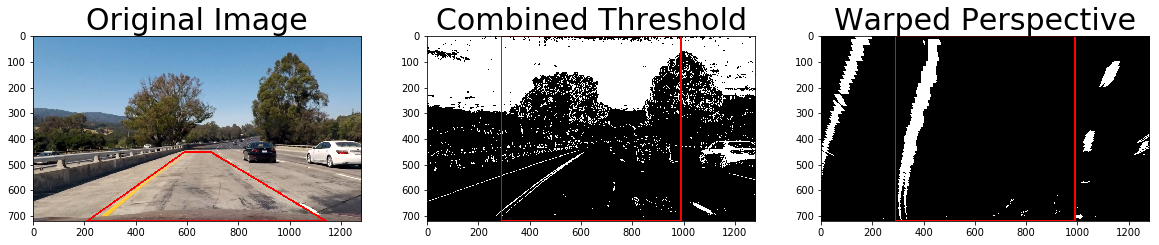

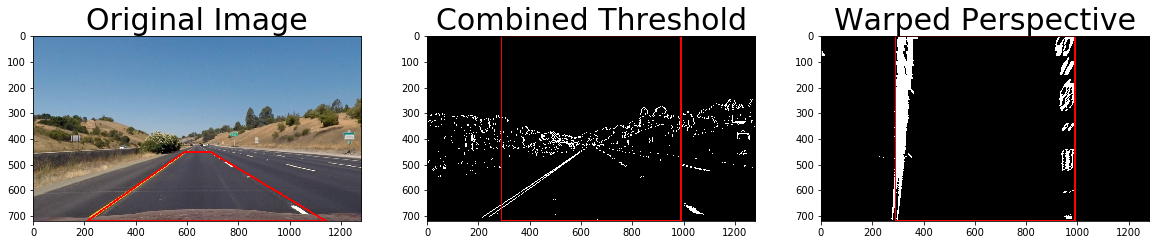

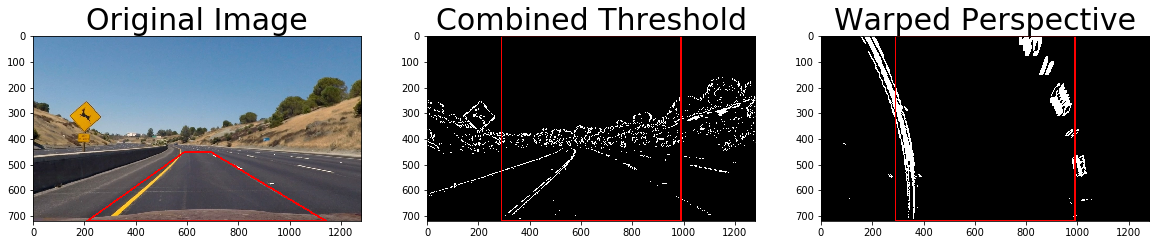

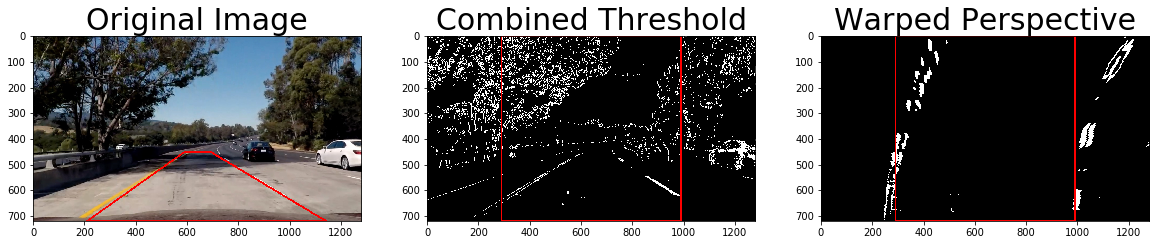

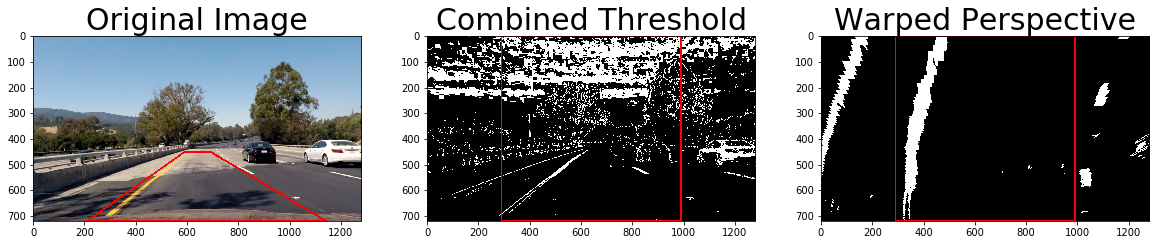

In [6]:
# testing combined
test_images = glob.glob('test_images/*.jpg')

for path in test_images:
    image = cv2.imread(path)
    helpers.visualize_perspective_transform(image)

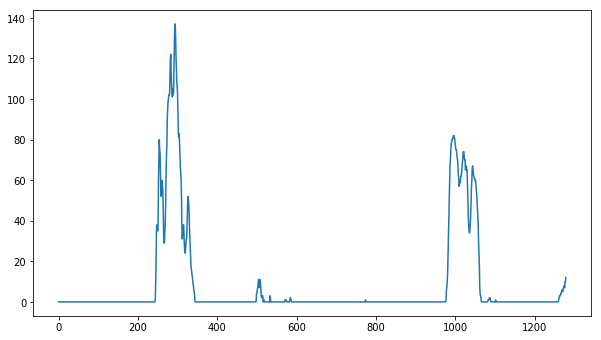

In [32]:
inp_img = cv2.imread(test_images[np.random.choice(len(test_images))])
(binary_warped, M), (binary_unwarped, Minv) = pipeline.binary_warp_unwarp(inp_img)

# Take a histogram of the bottom half of the image
histogram = histogram = pipeline.lane_histogram(binary_warped)
plt.figure(figsize=(10,5.625))
plt.plot(histogram)

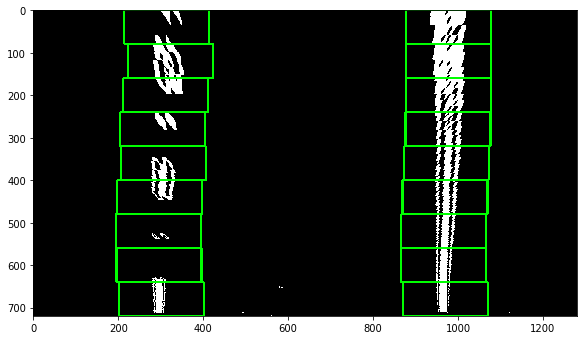

In [8]:
pts, out_img = pipeline.find_lane_pts(binary_warped, visualize=True)

plt.figure(figsize=(10,5.625))
plt.imshow(out_img)

(720, 0)

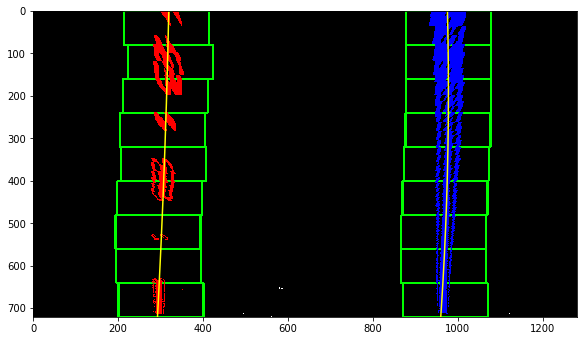

In [9]:
# Fit second order polynomial to these points
pipeline.polyfit_lanes(pts)

# Generate x and y values for plotting
ycoords = pipeline.polyfit_lane_coords(binary_warped.shape[0])

# color the left lane red andt the right lane blue
out_img[pts['lefty'], pts['leftx']] = [255, 0, 0]
out_img[pts['righty'], pts['rightx']] = [0, 0, 255]

plt.figure(figsize=(10,5.625))
plt.imshow(out_img)
plt.plot(pipeline.left.xfit, ycoords, color='yellow')
plt.plot(pipeline.right.xfit, ycoords, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

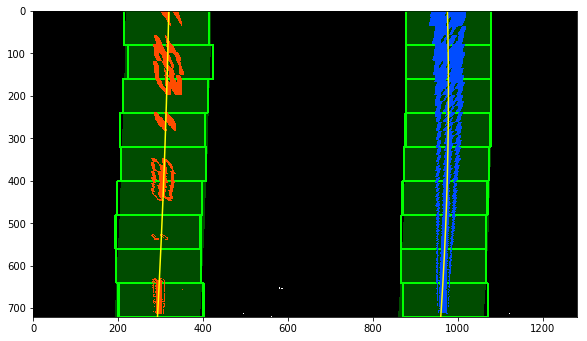

In [10]:
margin = 100
window_img = np.zeros_like(out_img)

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([pipeline.left.xfit-margin, ycoords]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([pipeline.left.xfit+margin, 
                              ycoords])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([pipeline.right.xfit-margin, ycoords]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([pipeline.right.xfit+margin, 
                              ycoords])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.figure(figsize=(10,5.625))
plt.imshow(result)
plt.plot(pipeline.left.xfit, ycoords, color='yellow')
plt.plot(pipeline.right.xfit, ycoords, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

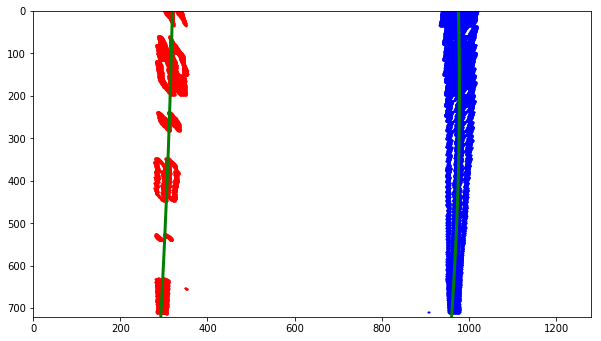

In [11]:
# Plot only the discovered points and the fit polynomial lines
mark_size = 1
plt.figure(figsize=(10,5.625))
plt.plot(pts["leftx"], pts["lefty"], 'o', color='red', markersize=mark_size)
plt.plot(pts["rightx"], pts["righty"], 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(pipeline.left.xfit, ycoords, color='green', linewidth=3)
plt.plot(pipeline.right.xfit, ycoords, color='green', linewidth=3)
plt.gca().invert_yaxis()  # to visualize as we do the images

In [31]:
# measure the curatures for each line, and then average it to return a single value
pipeline.measure_curvature(ycoords)

print(str(int(np.mean([pipeline.left.radius_of_curvature, pipeline.right.radius_of_curvature]))) + "m")

7021m


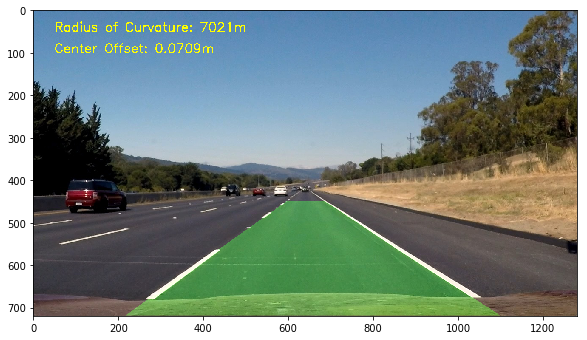

In [30]:
img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
result = pipeline.find_lanes(img)

plt.figure(figsize=(10,5.625))
plt.imshow(result)